<a href="https://colab.research.google.com/github/moriyatur/GANs_models/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 1. Import required libraries

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import imageio
import numpy as np
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import torch.optim as optim
import matplotlib.pyplot as plt
import itertools
import math

# Mount data from drive
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
#@title 2. Hyper-parameters

n_epochs = 250          # number of epochs of training
batch_size = 64         # size of the batches
number_of_chanels = 1   # number of image channels
number_of_features = 16 # size of each image dimension
latent_dim=100          # dimensionality of the latent space
print_every = 100
real_label = 1
fake_label = 0
noise_size = 100

# Adam optimizers
lr = 1e-4               # learning rate
betas = (.9, .99)       # decay of first order momentum of gradient

cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **WGAN_GP**
Wasserstein GANs with Gradient Penalty

In [ ]:
#@title 3. Generator and Discriminator for WGAN_GP Models
class wgan_generator(nn.Module):
    def __init__(self):
      super(wgan_generator, self).__init__()
      self.network = nn.Sequential(

          nn.ConvTranspose2d(noise_size, number_of_features*4, 4, 1, 0),
          nn.ReLU(),
          nn.BatchNorm2d(4 * number_of_features),
          nn.ConvTranspose2d(number_of_features*4, number_of_features*2, 3, 2, 1,),
          nn.ReLU(),
          nn.BatchNorm2d(2 * number_of_features),
          nn.ConvTranspose2d(number_of_features*2, number_of_features, 4, 2, 1,),
          nn.ReLU(),
          nn.BatchNorm2d(number_of_features),
          nn.ConvTranspose2d(number_of_features, number_of_chanels, 4, 2, 1),
          nn.Sigmoid()
      )

    def forward(self, input):
      output = self.network(input)
      return output

class wgan_discriminator(nn.Module):
    def __init__(self):
        super(wgan_discriminator, self).__init__()
        self.network = nn.Sequential(

                # in_channels, out_channels, kernel_size, stride, padding
                nn.Conv2d(number_of_chanels, number_of_features, 4, 2, 1),
                nn.LeakyReLU(0.2),

                nn.Conv2d(number_of_features, number_of_features * 2, 4, 2, 1),
                nn.LeakyReLU(0.2),

                nn.Conv2d(number_of_features * 2, number_of_features * 4, 4, 2, 1),
                nn.LeakyReLU(0.2),

                nn.Conv2d(number_of_features * 4, 1, 3, 2, 1),
                nn.Sigmoid()
            )
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

In [ ]:
#@title 4.Train WGAN_GP model

# Load the data FashionMnist
all_transforms = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST('./data',train=True,download=True,transform=all_transforms)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Initialize generator and discriminator
generator = wgan_generator()
discriminator = wgan_discriminator()

if(cuda):
  generator.cuda()
  discriminator.cuda()

# Initialize optimizers
gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas)
dis_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

loss_gen_vec = []
loss_dis_vec = []

# Default vales for WGAN_GP model
gp_lambda = 10    # The gradient penalty coefficient
n_critic = 5      # the number of critic iterations per generator iteration
epsilon = 1e-12   # Derivatives of the gradient close to 0 can cause problems because of
                  # the square root, so manually calculate norm and add epsilon
loss_gradient_norm = []
loss_gp = []

for epoch in range(n_epochs):
  print(f'\nEpoch {epoch+1}/{n_epochs} [===================] ')

  for i, (img, _) in enumerate(train_loader):

    batch_size = img.shape[0]

    real_images = img.to(device)

    # Sample noise as generator input
    noise = torch.randn(batch_size, noise_size, 1, 1, device=device)

    fake_images = generator(noise)
    discriminator(real_images)
    # --------------------- #
    #    Gradient Penalty   #
    # --------------------- #
    # Sample alpha from uniform distribution
    alpha = torch.rand(batch_size, 1, 1, 1)
    alpha = alpha.expand_as(real_images)
    if(cuda): alpha = alpha.cuda()

    # Interpolation between real data and fake data.
    interpolated = alpha * real_images.data + (1 - alpha) * fake_images.data
    interpolated = Variable(interpolated, requires_grad=True)
    if(cuda):
        interpolated = interpolated.cuda()
    # get logits for interpolated images
    interp_logits = discriminator(interpolated)

    # Compute Gradients
    gradients = torch_grad(outputs=interp_logits,
            inputs=interpolated,
            grad_outputs=torch.ones(interp_logits.size()).cuda()
            if cuda else torch.ones_like(interp_logits),
            create_graph=True,
            retain_graph=True,
            allow_unused=True,
            )[0]
    # Calculate gradients of probabilities with respect to examples
    gradients = gradients.view(batch_size, -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + epsilon)
    gradient_penalty = gp_lambda * ((gradients_norm - 1) ** 2).mean()

    loss_gp.append(gradient_penalty.data)
    loss_gradient_norm.append(gradients.norm(2, dim=1).mean().data)

    # --------------------- #
    #  Train Discriminator  #
    # --------------------- #
    discriminator.zero_grad()

    dis_output_real = discriminator(real_images)
    dis_output_fake = discriminator(fake_images)
    loss_dis = dis_output_fake.mean() - dis_output_real.mean() + gradient_penalty
    loss_dis.backward(retain_graph=True)
    dis_optimizer.step()

    loss_dis_vec.append(loss_dis.data)

    # ----------------- #
    #  Train Generator  #
    # ----------------- #
    if i % n_critic == 0:

      generator.zero_grad()
      dis_output_fake = discriminator(fake_images)
      loss_gen = - dis_output_fake.mean()
      loss_gen.backward(retain_graph=True)
      gen_optimizer.step()

      loss_gen_vec.append(loss_gen.data)

    if (i % print_every == 0) and (i > n_critic):
      print("[Batch %d/%d]" % (i+1, len(train_loader)))
      print("[D loss: %f] [G loss: %f]" % ( loss_dis.item(), loss_gen.item()))
      print("[GP loss: %f] [Gradient Norm loss: %f]" % ( loss_gp[-1], loss_gradient_norm[-1]))

  # Generate batch of images and convert to grid
  fake_images_grid = make_grid(fake_images.data).cpu()
  fake_images_grid = np.transpose(fake_images_grid.numpy(), (1, 2, 0))
  plt.imshow((fake_images_grid * 255).astype(np.uint8))
  plt.title('Epoch_{}'.format(epoch+1))
  plt.show()

# Save models
name = 'Fmnist_model_WGAN_GP'
print(f'Save ' + name)
torch.save(discriminator.state_dict(), f'/content/drive/My Drive/models/Q4/' + name + '_discriminator.pt')
torch.save(generator.state_dict(), f'/content/drive/My Drive/models/Q4/' + name + '_generator.pt')

np.save(f'/content/drive/My Drive/models/Q4/' + name + '_loss_gen_vec.npy', torch.Tensor(loss_gen_vec))
np.save(f'/content/drive/My Drive/models/Q4/' + name + '_loss_dis_vec.npy', torch.Tensor(loss_dis_vec))


# ***DCGAN***
deep convolutional generative adversarial networks (DCGANs)

In [ ]:
#@title 5. Generator and Discriminator for DCGAN Models
class dcgan_generator(nn.Module):
    def __init__(self):
      super(dcgan_generator, self).__init__()
      self.network = nn.Sequential(

          nn.ConvTranspose2d(noise_size , number_of_features*8, 4, 1, 0, bias=False),
          nn.BatchNorm2d(number_of_features*8),
          nn.ReLU(True),

          nn.ConvTranspose2d(number_of_features*8, number_of_features*4, 3, 2, 1, bias=False),
          nn.BatchNorm2d(number_of_features*4),
          nn.ReLU(True),

          nn.ConvTranspose2d(number_of_features*4, number_of_features*2, 4, 2, 1, bias=False),
          nn.BatchNorm2d(number_of_features*2),
          nn.ReLU(True),

          nn.ConvTranspose2d(number_of_features*2, number_of_chanels, 4, 2, 1, bias=False),
          nn.Tanh()
      )

    def forward(self, input):
      output = self.network(input)
      return output


class dcgan_discriminator(nn.Module):
    def __init__(self):
        super(dcgan_discriminator, self).__init__()
        self.network = nn.Sequential(

                nn.Conv2d(number_of_chanels, number_of_features*2, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(number_of_features*2, number_of_features*4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(number_of_features*4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(number_of_features*4, number_of_features*8, 3, 2, 1, bias=False),
                nn.BatchNorm2d(number_of_features*8),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(number_of_features*8, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

In [ ]:
#@title 6.Train DCGAN model

# Load the data FashionMnist
all_transforms = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST('./data',train=True,download=True,transform=all_transforms)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Initialize generator and discriminator
generator = dcgan_generator()
discriminator = dcgan_discriminator()
if(cuda):
  generator.cuda()
  discriminator.cuda()

# Initialize optimizers
gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas)
dis_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

# Loss function
criterion_loss = torch.nn.BCELoss()
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

loss_gen_vec = []
loss_dis_vec = []

for epoch in range(n_epochs):
  print(f'\nEpoch {epoch+1}/{n_epochs} [===================] ')

  for i, (imgs, _) in enumerate(train_loader):

      batch_size = imgs.shape[0]

      real_images = imgs.to(device)
      label = torch.full((batch_size,), real_label, device=device, dtype=torch.float)

      # Sample noise as generator input
      noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
      fake_images = generator(noise)

      # --------------------- #
      #  Train Discriminator  #
      # --------------------- #
      discriminator.zero_grad()

      # Measure discriminator's ability to classify real from generated samples
      real_loss = criterion_loss(discriminator(real_images), label)
      real_loss.backward()
      fake_loss = criterion_loss(discriminator(fake_images.detach()), label.fill_(fake_label))
      fake_loss.backward()

      loss_dis = real_loss + fake_loss
      loss_dis_vec.append(loss_dis.data)
      dis_optimizer.step()

      # ----------------- #
      #  Train Generator  #
      # ----------------- #
      generator.zero_grad()

      loss_gen = criterion_loss(discriminator(fake_images), label.fill_(real_label))
      loss_gen.backward()
      loss_gen_vec.append(loss_gen.data)
      gen_optimizer.step()

      if i % print_every == 0:
        print("[Batch %d/%d] [D loss: %f] [G loss: %f]"
          % (i+1, len(train_loader), loss_dis.item(), loss_gen.item()))

  # Generate batch of fake images and convert to grid
  fake_images_grid = make_grid(fake_images.data).cpu()
  fake_images_grid = np.transpose(fake_images_grid.numpy(), (1, 2, 0))
  imgplot = plt.imshow(fake_images_grid)
  plt.title('Epoch_{}'.format(epoch+1))
  plt.show()

  generator.eval()
  generator.train()

# Save models
name = 'Fmnist_model_DCGAN'
print(f'Save ' + name)
torch.save(discriminator.state_dict(), f'/content/drive/My Drive/models/Q4/' + name + '_discriminator.pt')
torch.save(generator.state_dict(), f'/content/drive/My Drive/models/Q4/' + name + '_generator.pt')

np.save(f'/content/drive/My Drive/models/Q4/' + name + '_loss_gen_vec.npy', torch.Tensor(loss_gen_vec))
np.save(f'/content/drive/My Drive/models/Q4/' + name + '_loss_dis_vec.npy', torch.Tensor(loss_dis_vec))

G_DCGAN = loss_gen_vec
D_DCGAN = loss_dis_vec



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title 7. Visualize real images set
import matplotlib.pyplot as plt
%matplotlib inline

# Load the data FashionMnist
all_transforms = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST('./data',train=True,download=True,transform=all_transforms)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

dataiter = iter(train_loader)
images, labels = next(dataiter)

# specify the image classes
classes = ['top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'boot']

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')

  class_index=labels[idx]
  ax.set_title(classes[class_index])

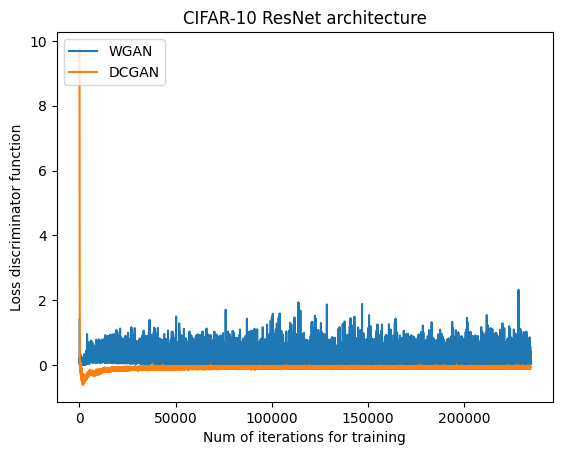

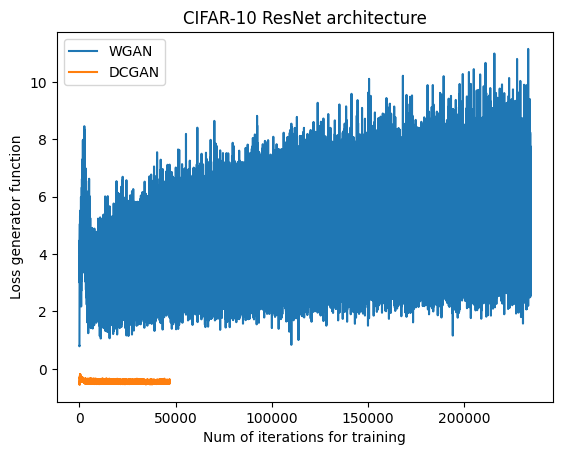

In [ ]:
#@title 8. the loss function
loss_dis_vec_dcgan = np.load(f'/content/drive/My Drive/models/Q4/Fmnist_model_WGAN_GP_loss_dis_vec.npy')
loss_dis_vec_wgan_gp = np.load(f'/content/drive/My Drive/models/Q4/Fmnist_model_DCGAN_loss_dis_vec.npy')


plt.plot(range(len(loss_dis_vec_wgan_gp)), torch.Tensor(loss_dis_vec_wgan_gp), label='WGAN')
plt.plot(range(len(loss_dis_vec_dcgan)),  torch.Tensor(loss_dis_vec_dcgan), label='DCGAN')

plt.xlabel("Num of iterations for training")
plt.ylabel("Loss discriminator function")

plt.legend(loc='upper left')
plt.title('CIFAR-10 ResNet architecture')
plt.show()


loss_gen_vec_dcgan = np.load(f'/content/drive/My Drive/models/Q4/Fmnist_model_WGAN_GP_loss_gen_vec.npy')
loss_gen_vec_wgan_gp = np.load(f'/content/drive/My Drive/models/Q4/Fmnist_model_DCGAN_loss_gen_vec.npy')


plt.plot(range(len(loss_gen_vec_wgan_gp)), torch.Tensor(loss_gen_vec_wgan_gp), label='WGAN')
plt.plot(range(len(loss_gen_vec_dcgan)),  torch.Tensor(loss_gen_vec_dcgan), label='DCGAN')

plt.xlabel("Num of iterations for training")
plt.ylabel("Loss generator function")

plt.legend(loc='upper left')
plt.title('CIFAR-10 ResNet architecture')
plt.show()
